In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [3]:
full_df = pd.read_csv('stats_0z.csv')

event = "tornado"
df = full_df[full_df["event"] == event].copy()
df.index = range(len(df))
df

,event,days_count,threshold,spc_threshold_days,nadocast_threshold_days,spc_success_ratio,spc_pod,spc_false_positive_rate,nadocast_success_ratio,nadocast_pod,...,spc_pod_0.975_bootstrap,spc_csi_0.025_bootstrap,spc_csi_0.975_bootstrap,nadocast_success_ratio_0.025_bootstrap,nadocast_success_ratio_0.975_bootstrap,nadocast_pod_0.025_bootstrap,nadocast_pod_0.975_bootstrap,nadocast_csi_0.025_bootstrap,nadocast_csi_0.975_bootstrap,p_value_nadocast_csi_better
0,tornado,155,0.01,79,115,0.059523,0.698779,0.025721,0.053505,0.869162,...,0.800514,0.038655,0.078670,0.038525,0.069963,0.795803,0.918322,0.038166,0.069417,0.923028
1,tornado,155,0.02,79,95,0.059523,0.698779,0.025721,0.078714,0.778767,...,0.800489,0.038641,0.078710,0.056571,0.101627,0.674510,0.852150,0.055178,0.099669,0.000000
2,tornado,155,0.05,34,51,0.139708,0.412009,0.005910,0.184460,0.510947,...,0.568049,0.068865,0.157571,0.131549,0.230780,0.335539,0.648080,0.105990,0.201115,0.000069
3,tornado,155,0.10,9,17,0.262528,0.173505,0.001135,0.346902,0.225244,...,0.289610,0.039951,0.167735,0.196908,0.458138,0.072275,0.361922,0.057580,0.237541,0.063598
4,tornado,155,0.15,3,8,0.365153,0.089459,0.000362,0.286627,0.026679,...,0.183350,0.000000,0.143967,0.118634,0.513235,0.001448,0.052485,0.001436,0.047604,0.949514
5,tornado,155,0.30,0,1,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
6,tornado,155,0.45,0,0,NaN,0.000000,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
7,tornado,155,0.60,0,0,NaN,0.000000,0.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


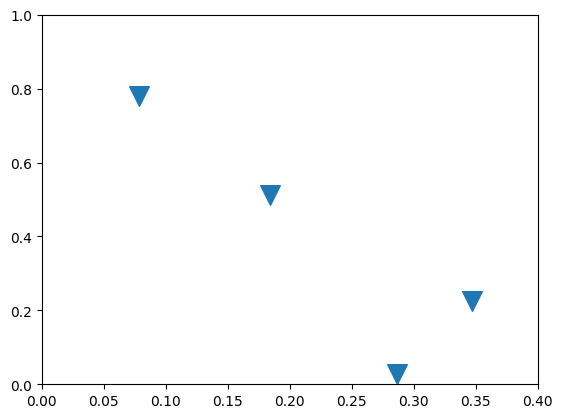

In [4]:
min_threshold = 0.02
nc_or_spc = "nadocast"
fig, ax = plt.subplots()
ax.set_xlim(0,.4)
ax.set_ylim(0,1)
row_is = (df[f"{nc_or_spc}_threshold_days"] >= 2) & (df["threshold"] >= min_threshold)
xs = list(df[f"{nc_or_spc}_success_ratio"][row_is])
ys = list(df[f"{nc_or_spc}_pod"][row_is])
ax.scatter(xs, ys, s=200, marker="v")
plt.show()

def perf_plot(csv_path, nc_or_spc, event, min_threshold):
    full_df = pd.read_csv(csv_path)
    df = full_df[full_df["event"] == event].copy()
    df.index = range(len(df))
    fig, ax = plt.subplots()
    ax.set_xlim(0,.4)
    ax.set_ylim(0,1)
    row_is = (df[f"{nc_or_spc}_threshold_days"] >= 2) & (df["threshold"] >= min_threshold)
    xs = list(df[f"{nc_or_spc}_success_ratio"][row_is])
    ys = list(df[f"{nc_or_spc}_pod"][row_is])
    ax.scatter(xs, ys, s=200, marker="v")
    plt.show()

In [5]:
alpd = 0.0
last_y = 0.0
areas = []
# work in reverse order
for (x,y) in zip(xs[::-1],ys[::-1]):
    rect_area = x * (y - last_y) 
    areas.append(rect_area)
    last_y = y
areas

[0.007646825686352321,
 0.0688827375472485,
 0.052700744757495,
 0.021081221320278]

In [6]:
alpd = sum(areas)
alpd

0.15031152931137381

In [7]:
# via Sam Mason https://stackoverflow.com/a/56974893
def sig_figs(x, ndigits):
    if x == 0 or not math.isfinite(x):
        return x
    ndigits -= math.ceil(math.log10(abs(x)))
    return round(x, ndigits)

sig_figs(0.04336916143280999,3)

0.0434

In [8]:
def mean2(a, b):
    return (a + b) / 2.0

In [9]:
# Stairstep version
def alpd(csv_path, nc_or_spc, event, min_threshold, max_threshold=1.0):
    full_df = pd.read_csv(csv_path)

    df = full_df[full_df["event"] == event].copy()
    df.index = range(len(df))
    row_is = (df[f"{nc_or_spc}_threshold_days"] >= 2) & (df["threshold"] >= min_threshold) & (df["threshold"] <= max_threshold)
    xs = list(df[f"{nc_or_spc}_success_ratio"][row_is])
    xs = [0.0 if np.isnan(x) else x for x in xs]
    ys = list(df[f"{nc_or_spc}_pod"][row_is])
    last_y = 0.0
    areas = []
    # work in reverse order
    for (x,y) in zip(xs[::-1],ys[::-1]):
        rect_area = x * (y - last_y) 
        areas.append(rect_area)
        last_y = y
    return sum(areas)

In [9]:
alpd("stats_0z.csv", "nadocast", "wind", 0.02)

0.3194510210605947

In [10]:
for (event, min_threshold) in [("tornado", 0.02), ("wind", 0.05), ("wind_adj", 0.05), ("hail", 0.05)]:
    cells                 = [event]
    spc_0z                = alpd("stats_0z.csv", "spc",                           event, min_threshold)
    nc_0z                 = alpd("stats_0z.csv", "nadocast",                      event, min_threshold)
    nc_href_only_0z       = alpd("stats_0z_href_only.csv", "nadocast",            event, min_threshold)
    nc_2021_0z            = alpd("csvs_2021/stats_0z.csv", "nadocast",            event, min_threshold)
    nc_2021_href_only_0z  = alpd("csvs_2021/stats_0z_href_only.csv", "nadocast",  event, min_threshold)
    spc_12z               = alpd("stats_12z.csv", "spc",                          event, min_threshold)
    nc_12z                = alpd("stats_12z.csv", "nadocast",                     event, min_threshold)
    nc_href_only_12z      = alpd("stats_12z_href_only.csv", "nadocast",           event, min_threshold)
    nc_2021_12z           = alpd("csvs_2021/stats_12z.csv", "nadocast",           event, min_threshold)
    nc_2021_href_only_12z = alpd("csvs_2021/stats_12z_href_only.csv", "nadocast", event, min_threshold)
    cells.append(sig_figs(spc_0z, 3))
    cells.append(sig_figs(nc_0z, 3))
    cells.append(sig_figs(nc_href_only_0z, 3))
    cells.append(sig_figs(nc_2021_0z, 3))
    cells.append(sig_figs(nc_2021_href_only_0z, 3))
    cells.append(sig_figs(spc_12z, 3))
    cells.append(sig_figs(nc_12z, 3))
    cells.append(sig_figs(nc_href_only_12z, 3))
    cells.append(sig_figs(nc_2021_12z, 3))
    cells.append(sig_figs(nc_2021_href_only_12z, 3))
    cells.append(sig_figs(mean2(spc_0z, spc_12z), 3))
    cells.append(sig_figs(mean2(nc_0z, nc_12z), 3))
    cells.append(sig_figs(mean2(nc_href_only_0z, nc_href_only_12z), 3))
    cells.append(sig_figs(mean2(nc_2021_0z, nc_2021_12z), 3))
    cells.append(sig_figs(mean2(nc_2021_href_only_0z, nc_2021_href_only_12z), 3))
    print(",".join(map(str, cells)))

tornado,0.105,0.15,0.148,0.138,0.139,0.135,0.171,0.17,0.162,0.167,0.12,0.161,0.159,0.15,0.153
wind,0.196,0.308,0.312,0.3,0.305,0.237,0.334,0.34,0.34,0.344,0.216,0.321,0.326,0.32,0.324
wind_adj,0.0763,0.139,0.144,0,0,0.0928,0.167,0.166,0,0,0.0845,0.153,0.155,0.0,0.0
hail,0.102,0.195,0.196,0.192,0.193,0.129,0.224,0.224,0.221,0.223,0.116,0.21,0.21,0.207,0.208


In [11]:
for event in ["sig_tornado", "sig_wind", "sig_wind_adj", "sig_hail"]:
    cells = [event]
    spc_0z                = alpd("stats_0z.csv", "spc",                           event, 0.1, 0.1)
    nc_0z                 = alpd("stats_0z.csv", "nadocast",                      event, 0.1, 0.1)
    nc_href_only_0z       = alpd("stats_0z_href_only.csv", "nadocast",            event, 0.1, 0.1)
    nc_2021_0z            = alpd("csvs_2021/stats_0z.csv", "nadocast",            event, 0.1, 0.1)
    nc_2021_href_only_0z  = alpd("csvs_2021/stats_0z_href_only.csv", "nadocast",  event, 0.1, 0.1)
    spc_12z               = alpd("stats_12z.csv", "spc",                          event, 0.1, 0.1)
    nc_12z                = alpd("stats_12z.csv", "nadocast",                     event, 0.1, 0.1)
    nc_href_only_12z      = alpd("stats_12z_href_only.csv", "nadocast",           event, 0.1, 0.1)
    nc_2021_12z           = alpd("csvs_2021/stats_12z.csv", "nadocast",           event, 0.1, 0.1)
    nc_2021_href_only_12z = alpd("csvs_2021/stats_12z_href_only.csv", "nadocast", event, 0.1, 0.1)
    cells.append(sig_figs(spc_0z, 3))
    cells.append(sig_figs(nc_0z, 3))
    cells.append(sig_figs(nc_href_only_0z, 3))
    cells.append(sig_figs(nc_2021_0z, 3))
    cells.append(sig_figs(nc_2021_href_only_0z, 3))
    cells.append(sig_figs(spc_12z, 3))
    cells.append(sig_figs(nc_12z, 3))
    cells.append(sig_figs(nc_href_only_12z, 3))
    cells.append(sig_figs(nc_2021_12z, 3))
    cells.append(sig_figs(nc_2021_href_only_12z, 3))
    cells.append(sig_figs(mean2(spc_0z, spc_12z), 3))
    cells.append(sig_figs(mean2(nc_0z, nc_12z), 3))
    cells.append(sig_figs(mean2(nc_href_only_0z, nc_href_only_12z), 3))
    cells.append(sig_figs(mean2(nc_2021_0z, nc_2021_12z), 3))
    cells.append(sig_figs(mean2(nc_2021_href_only_0z, nc_2021_href_only_12z), 3))
    print(",".join(map(str, cells)))

sig_tornado,0.0434,0.0634,0.0656,0.0588,0.0578,0.0527,0.0809,0.0764,0.0679,0.0726,0.048,0.0722,0.071,0.0633,0.0652
sig_wind,0.0113,0.0267,0.0239,0.0258,0.0255,0.0221,0.0416,0.0435,0.046,0.0447,0.0167,0.0342,0.0337,0.0359,0.0351
sig_wind_adj,0.00703,0.0111,0.0115,0,0,0.0121,0.0105,0.0166,0,0,0.00958,0.0108,0.0141,0.0,0.0
sig_hail,0.0111,0.0378,0.0428,0.0336,0.0346,0.0272,0.0493,0.0529,0.0406,0.0423,0.0191,0.0435,0.0478,0.0371,0.0385


In [12]:
print(",".join(["", "0600 SPC", "0Z NC", "1630 SPC", "12Z NC"]))
ablation_events = ["tornado_mean_58", "tornado_prob_80", "tornado_mean_prob_138", "tornado_mean_prob_computed_no_sv_219", "tornado_mean_prob_computed_220", "tornado_mean_prob_computed_partial_climatology_227", "tornado_mean_prob_computed_climatology_253", "tornado_mean_prob_computed_climatology_blurs_910", "tornado_mean_prob_computed_climatology_grads_1348", "tornado_mean_prob_computed_climatology_blurs_grads_2005", "tornado_mean_prob_computed_climatology_prior_next_hrs_691", "tornado_mean_prob_computed_climatology_3hr_1567", "tornado_full_13831"]
for event in ablation_events:
    cells = [event]
    cells.append(alpd("stats_0z_href_ablations.csv", "spc", event, 0.02))
    cells.append(alpd("stats_0z_href_ablations.csv", "nadocast", event, 0.02))
    cells.append(alpd("stats_12z_href_ablations.csv", "spc", event, 0.02))
    cells.append(alpd("stats_12z_href_ablations.csv", "nadocast", event, 0.02))
    print(",".join(map(str, cells)))


,0600 SPC,0Z NC,1630 SPC,12Z NC
tornado_mean_58,0.10512085229687604,0.12177853146828498,0.1354641477693047,0.1471248316544583
tornado_prob_80,0.10512085229687604,0.13470451243983028,0.1354641477693047,0.15841930060751858
tornado_mean_prob_138,0.10512085229687604,0.136950628874552,0.1354641477693047,0.1721645850920504
tornado_mean_prob_computed_no_sv_219,0.10512085229687604,0.13102019198912102,0.1354641477693047,0.17319848767371146
tornado_mean_prob_computed_220,0.10512085229687604,0.1343288360444887,0.1354641477693047,0.172578075568509
tornado_mean_prob_computed_partial_climatology_227,0.10512085229687604,0.138485169069659,0.1354641477693047,0.1758087305255236
tornado_mean_prob_computed_climatology_253,0.10512085229687604,0.14936111251012682,0.1354641477693047,0.18376694522201903
tornado_mean_prob_computed_climatology_blurs_910,0.10512085229687604,0.154066270595307,0.1354641477693047,0.1868261364541888
tornado_mean_prob_computed_climatology_grads_1348,0.10512085229687604,0.142200508422

In [13]:
print(",".join(["", "Feature Count", "0Z", "12Z"]))
ablation_events = ["tornado_mean_58", "tornado_prob_80", "tornado_mean_prob_138", "tornado_mean_prob_computed_no_sv_219", "tornado_mean_prob_computed_220", "tornado_mean_prob_computed_partial_climatology_227", "tornado_mean_prob_computed_climatology_253", "tornado_mean_prob_computed_climatology_blurs_910", "tornado_mean_prob_computed_climatology_grads_1348", "tornado_mean_prob_computed_climatology_blurs_grads_2005", "tornado_mean_prob_computed_climatology_prior_next_hrs_691", "tornado_mean_prob_computed_climatology_3hr_1567", "tornado_full_13831"]
import re
for event in ablation_events:
    cells = [event, re.compile(r"_(\d+)$").search(event)[1]]
    cells.append(alpd("stats_0z_href_ablations_absolutely_calibrated.csv", "nadocast", event, 0.02))
    cells.append(alpd("stats_12z_href_ablations_absolutely_calibrated.csv", "nadocast", event, 0.02))
    print(",".join(map(str, cells)))


,Feature Count,0Z,12Z
tornado_mean_58,58,0.1303996707124582,0.1538716732600313
tornado_prob_80,80,0.13835021822828833,0.1657199043591926
tornado_mean_prob_138,138,0.1481947276283812,0.1803547607772805
tornado_mean_prob_computed_no_sv_219,219,0.1376053781801045,0.17617773291263714
tornado_mean_prob_computed_220,220,0.14011941399774486,0.1775051580535952
tornado_mean_prob_computed_partial_climatology_227,227,0.1476047227625965,0.1841853529692912
tornado_mean_prob_computed_climatology_253,253,0.16047809852413591,0.19471398909698992
tornado_mean_prob_computed_climatology_blurs_910,910,0.15904320085444382,0.19227482572587468
tornado_mean_prob_computed_climatology_grads_1348,1348,0.15138965577517677,0.19139405681733934
tornado_mean_prob_computed_climatology_blurs_grads_2005,2005,0.14903195068551944,0.19304865551050082
tornado_mean_prob_computed_climatology_prior_next_hrs_691,691,0.1576864785994551,0.20148000961504914
tornado_mean_prob_computed_climatology_3hr_1567,1567,0.15579727564314338,0.

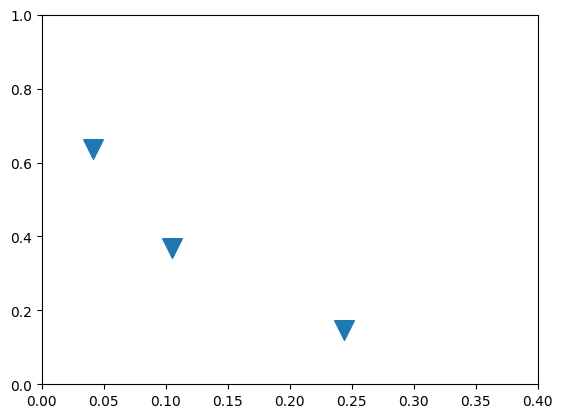

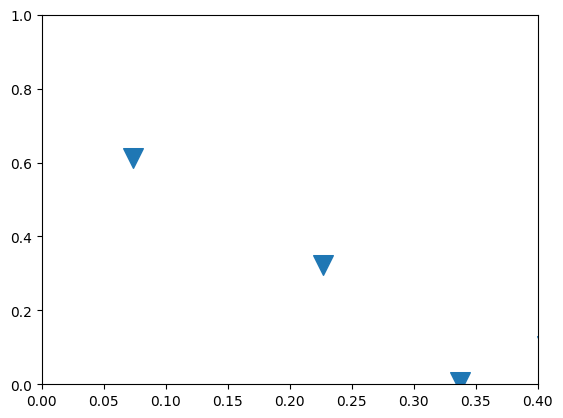

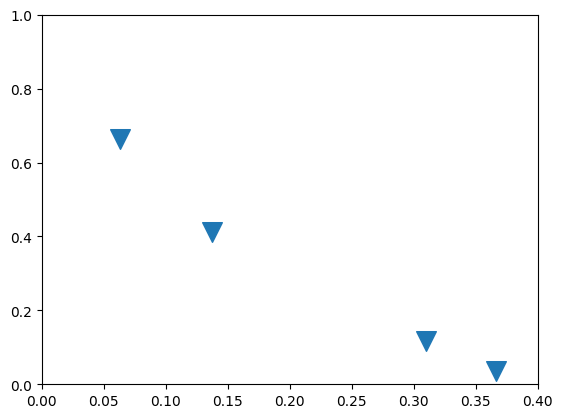

In [14]:
perf_plot("stats_14z_2020_models_tornado_with_hrrr.csv",                   "spc",      "tornado", 0.02)
perf_plot("stats_14z_2020_models_tornado_with_hrrr.csv",                   "nadocast", "tornado", 0.02)
perf_plot("stats_12z_2021_models_tornado_href_sref.csv",                   "nadocast", "tornado", 0.02)

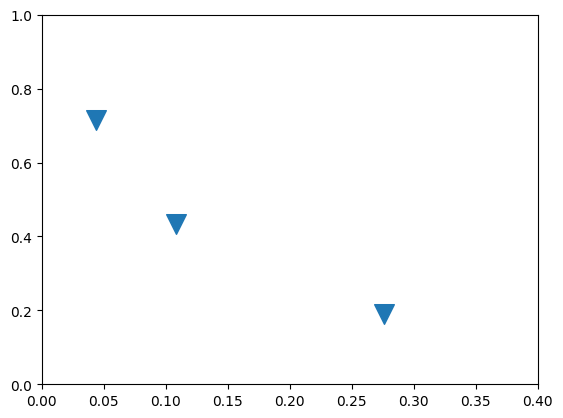

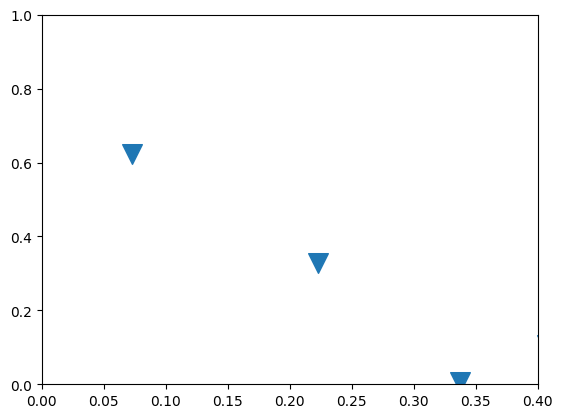

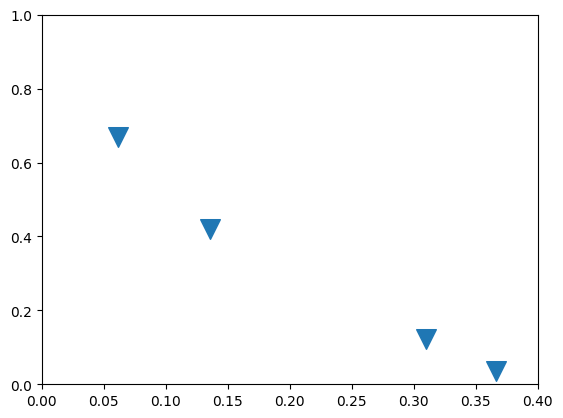

In [15]:
perf_plot("stats_14z_2020_models_tornado_with_hrrr_vs_1630_tornadoes.csv", "spc",      "tornado", 0.02)
perf_plot("stats_14z_2020_models_tornado_with_hrrr_vs_1630_tornadoes.csv", "nadocast", "tornado", 0.02)
perf_plot("stats_12z_2021_models_tornado_href_sref_vs_1630_tornadoes.csv", "nadocast", "tornado", 0.02)

In [16]:
# stats_12z_2021_models_tornado_href_sref.csv
# stats_12z_2021_models_tornado_href_sref_vs_1630_tornadoes.csv
# stats_14z_2020_models_tornado_with_hrrr.csv
# stats_14z_2020_models_tornado_with_hrrr_vs_1630_tornadoes.csv

headers = [
    "event",
    "SPC",
    "14Z NC 2020 (w/HRRR)",
    "12Z NC 2021",
]
print(",".join(map(str, headers)))

cells = [
    "tornado vs 0600 SPC",
    sig_figs(alpd("stats_14z_2020_models_tornado_with_hrrr.csv",                   "spc",      "tornado", 0.02), 3),
    sig_figs(alpd("stats_14z_2020_models_tornado_with_hrrr.csv",                   "nadocast", "tornado", 0.02), 3),
    sig_figs(alpd("stats_12z_2021_models_tornado_href_sref.csv",                   "nadocast", "tornado", 0.02), 3),
]
print(",".join(map(str, cells)))

cells = [
    "tornado vs 1630 SPC",
    sig_figs(alpd("stats_14z_2020_models_tornado_with_hrrr_vs_1630_tornadoes.csv", "spc",      "tornado", 0.02), 3),
    sig_figs(alpd("stats_14z_2020_models_tornado_with_hrrr_vs_1630_tornadoes.csv", "nadocast", "tornado", 0.02), 3),
    sig_figs(alpd("stats_12z_2021_models_tornado_href_sref_vs_1630_tornadoes.csv", "nadocast", "tornado", 0.02), 3),
]
print(",".join(map(str, cells)))

event,SPC,14Z NC 2020 (w/HRRR),12Z NC 2021
tornado vs 0600 SPC,0.0702,0.113,0.0957
tornado vs 1630 SPC,0.109,0.114,0.0966


In [17]:
for (event, min_threshold, max_threshold) in [("tornado", 0.02, 1.0), ("wind", 0.05, 1.0), ("hail", 0.05, 1.0), ("sig_tornado", 0.1, 0.1)]:
    cells                    = [event]
    spc_0z                   = alpd("stats_0z.csv", "spc",                                                 event, min_threshold, max_threshold)
    nc_0z                    = alpd("stats_0z.csv", "nadocast",                                            event, min_threshold, max_threshold)
    nc_href_only_0z          = alpd("stats_0z_href_only.csv", "nadocast",                                  event, min_threshold, max_threshold)
    nc_day_exp_0z            = alpd("stats_0z_href_day_experiment.csv", "nadocast",                        event, min_threshold, max_threshold)
    nc_day_exp_abs_calib_0z  = alpd("stats_0z_href_day_experiment_absolutely_calibrated.csv", "nadocast",  event, min_threshold, max_threshold)
    spc_12z                  = alpd("stats_12z.csv", "spc",                                                event, min_threshold, max_threshold)
    nc_12z                   = alpd("stats_12z.csv", "nadocast",                                           event, min_threshold, max_threshold)
    nc_href_only_12z         = alpd("stats_12z_href_only.csv", "nadocast",                                 event, min_threshold, max_threshold)
    nc_day_exp_12z           = alpd("stats_12z_href_day_experiment.csv", "nadocast",                       event, min_threshold, max_threshold)
    nc_day_exp_abs_calib_12z = alpd("stats_12z_href_day_experiment_absolutely_calibrated.csv", "nadocast", event, min_threshold, max_threshold)
    cells.append(sig_figs(spc_0z, 3))
    cells.append(sig_figs(nc_0z, 3))
    cells.append(sig_figs(nc_href_only_0z, 3))
    cells.append(sig_figs(nc_day_exp_0z, 3))
    cells.append(sig_figs(nc_day_exp_abs_calib_0z, 3))
    cells.append(sig_figs(spc_12z, 3))
    cells.append(sig_figs(nc_12z, 3))
    cells.append(sig_figs(nc_href_only_12z, 3))
    cells.append(sig_figs(nc_day_exp_12z, 3))
    cells.append(sig_figs(nc_day_exp_abs_calib_12z, 3))
    cells.append(sig_figs(mean2(spc_0z, spc_12z), 3))
    cells.append(sig_figs(mean2(nc_0z, nc_12z), 3))
    cells.append(sig_figs(mean2(nc_href_only_0z, nc_href_only_12z), 3))
    cells.append(sig_figs(mean2(nc_day_exp_0z, nc_day_exp_12z), 3))
    cells.append(sig_figs(mean2(nc_day_exp_abs_calib_0z, nc_day_exp_abs_calib_12z), 3))
    print(",".join(map(str, cells)))

tornado,0.105,0.15,0.148,0.117,0.122,0.135,0.171,0.17,0.152,0.152,0.12,0.161,0.159,0.134,0.137
wind,0.196,0.308,0.312,0.302,0.33,0.237,0.334,0.34,0.334,0.358,0.216,0.321,0.326,0.318,0.344
hail,0.102,0.195,0.196,0.194,0.205,0.129,0.224,0.224,0.213,0.227,0.116,0.21,0.21,0.203,0.216
sig_tornado,0.0434,0.0634,0.0656,0.0478,0.059,0.0527,0.0809,0.0764,0.0384,0.0406,0.048,0.0722,0.071,0.0431,0.0498


In [21]:
for (event, min_threshold, max_threshold) in [("tornado", 0.02, 1.0), ("wind", 0.05, 1.0), ("hail", 0.05, 1.0)]:
    cells = [event]
    spc_0z                                  = alpd("stats_0z.csv",                                        "spc",      event,                                                               min_threshold, max_threshold)                                              
    nc_href_only_0z                         = alpd("stats_0z_href_only.csv",                              "nadocast", event,                                                               min_threshold, max_threshold)                                              
    nc_href_only_abs_calib_0z               = alpd("stats_0z_href_only_absolutely_calibrated.csv",        "nadocast", event,                                                               min_threshold, max_threshold)                                              
    nc_best_ablated_0z                      = alpd("stats_0z_href_ablations2.csv",                        "nadocast", event + "_mean_prob_computed_climatology_blurs_910",                 min_threshold, max_threshold)
    nc_best_ablated_abs_calib_0z            = alpd("stats_0z_href_ablations2_absolutely_calibrated.csv",  "nadocast", event + "_mean_prob_computed_climatology_blurs_910",                 min_threshold, max_threshold)
    nc_best_ablated_half_data_0z            = alpd("stats_0z_href_ablations2.csv",                        "nadocast", event + "_mean_prob_computed_climatology_blurs_910_before_20200523", min_threshold, max_threshold)
    nc_best_ablated_half_data_abs_calib_0z  = alpd("stats_0z_href_ablations2_absolutely_calibrated.csv",  "nadocast", event + "_mean_prob_computed_climatology_blurs_910_before_20200523", min_threshold, max_threshold)
    nc_unablated_0z                         = alpd("stats_0z_href_ablations2.csv",                        "nadocast", event + "_full_13831",                                               min_threshold, max_threshold)
    nc_unablated_abs_calib_0z               = alpd("stats_0z_href_ablations2_absolutely_calibrated.csv",  "nadocast", event + "_full_13831",                                               min_threshold, max_threshold)
    spc_12z                                 = alpd("stats_12z.csv",                                       "spc",      event,                                                               min_threshold, max_threshold)                                              
    nc_href_only_12z                        = alpd("stats_12z_href_only.csv",                             "nadocast", event,                                                               min_threshold, max_threshold)                                              
    nc_href_only_abs_calib_12z              = alpd("stats_12z_href_only_absolutely_calibrated.csv",       "nadocast", event,                                                               min_threshold, max_threshold)                                              
    nc_best_ablated_12z                     = alpd("stats_12z_href_ablations2.csv",                       "nadocast", event + "_mean_prob_computed_climatology_blurs_910",                 min_threshold, max_threshold)
    nc_best_ablated_abs_calib_12z           = alpd("stats_12z_href_ablations2_absolutely_calibrated.csv", "nadocast", event + "_mean_prob_computed_climatology_blurs_910",                 min_threshold, max_threshold)
    nc_best_ablated_half_data_12z           = alpd("stats_12z_href_ablations2.csv",                       "nadocast", event + "_mean_prob_computed_climatology_blurs_910_before_20200523", min_threshold, max_threshold)
    nc_best_ablated_half_data_abs_calib_12z = alpd("stats_12z_href_ablations2_absolutely_calibrated.csv", "nadocast", event + "_mean_prob_computed_climatology_blurs_910_before_20200523", min_threshold, max_threshold)
    nc_unablated_12z                        = alpd("stats_12z_href_ablations2.csv",                       "nadocast", event + "_full_13831",                                               min_threshold, max_threshold)
    nc_unablated_abs_calib_12z              = alpd("stats_12z_href_ablations2_absolutely_calibrated.csv", "nadocast", event + "_full_13831",                                               min_threshold, max_threshold)
    cells.append(sig_figs(spc_0z, 3))
    cells.append(sig_figs(nc_href_only_0z, 3))
    cells.append(sig_figs(nc_href_only_abs_calib_0z, 3))
    cells.append(sig_figs(nc_best_ablated_0z, 3))
    cells.append(sig_figs(nc_best_ablated_abs_calib_0z, 3))
    cells.append(sig_figs(nc_best_ablated_half_data_0z, 3))
    cells.append(sig_figs(nc_best_ablated_half_data_abs_calib_0z, 3))
    cells.append(sig_figs(nc_unablated_0z, 3))
    cells.append(sig_figs(nc_unablated_abs_calib_0z, 3))
    cells.append(sig_figs(spc_12z, 3))
    cells.append(sig_figs(nc_href_only_12z, 3))
    cells.append(sig_figs(nc_href_only_abs_calib_12z, 3))
    cells.append(sig_figs(nc_best_ablated_12z, 3))
    cells.append(sig_figs(nc_best_ablated_abs_calib_12z, 3))
    cells.append(sig_figs(nc_best_ablated_half_data_12z, 3))
    cells.append(sig_figs(nc_best_ablated_half_data_abs_calib_12z, 3))
    cells.append(sig_figs(nc_unablated_12z, 3))
    cells.append(sig_figs(nc_unablated_abs_calib_12z, 3))
    cells.append(sig_figs(mean2(spc_0z, spc_12z), 3))
    cells.append(sig_figs(mean2(nc_href_only_0z, nc_href_only_12z), 3))
    cells.append(sig_figs(mean2(nc_href_only_abs_calib_0z, nc_href_only_abs_calib_12z), 3))
    cells.append(sig_figs(mean2(nc_best_ablated_0z, nc_best_ablated_12z), 3))
    cells.append(sig_figs(mean2(nc_best_ablated_abs_calib_0z, nc_best_ablated_abs_calib_12z), 3))
    cells.append(sig_figs(mean2(nc_best_ablated_half_data_0z, nc_best_ablated_half_data_12z), 3))
    cells.append(sig_figs(mean2(nc_best_ablated_half_data_abs_calib_0z, nc_best_ablated_half_data_abs_calib_12z), 3))
    cells.append(sig_figs(mean2(nc_unablated_0z, nc_unablated_12z), 3))
    cells.append(sig_figs(mean2(nc_unablated_abs_calib_0z, nc_unablated_abs_calib_12z), 3))
    print(",".join(map(str, cells)))

tornado,0.105,0.148,0.155,0.154,0.159,0.141,0.151,0.148,0.155,0.135,0.17,0.183,0.187,0.192,0.17,0.174,0.17,0.183,0.12,0.159,0.169,0.17,0.176,0.156,0.162,0.159,0.169
wind,0.196,0.312,0.342,0.304,0.336,0.294,0.322,0.313,0.342,0.237,0.34,0.372,0.333,0.36,0.324,0.348,0.34,0.372,0.216,0.326,0.357,0.319,0.348,0.309,0.335,0.326,0.357
hail,0.102,0.196,0.211,0.197,0.209,0.189,0.204,0.196,0.211,0.129,0.224,0.236,0.219,0.232,0.212,0.221,0.224,0.236,0.116,0.21,0.224,0.208,0.221,0.2,0.212,0.21,0.224


In [12]:
for suffix in ["_href_only", "_href_only_more_days", "_href_only_since_spc_implementation"]:
    print(suffix)
    for (event, min_threshold) in [("tornado", 0.02), ("wind", 0.05), ("hail", 0.05)]:
        cells                 = [event]
        spc_0z                = alpd(f"stats_0z{suffix}.csv",  "spc",      event, min_threshold)
        nc_0z                 = alpd(f"stats_0z{suffix}.csv",  "nadocast", event, min_threshold)
        spc_12z               = alpd(f"stats_12z{suffix}.csv", "spc",      event, min_threshold)
        nc_12z                = alpd(f"stats_12z{suffix}.csv", "nadocast", event, min_threshold)
        cells.append(sig_figs(spc_0z, 3))
        cells.append(sig_figs(nc_0z, 3))
        cells.append(sig_figs(spc_12z, 3))
        cells.append(sig_figs(nc_12z, 3))
        cells.append(sig_figs(mean2(spc_0z, spc_12z), 3))
        cells.append(sig_figs(mean2(nc_0z, nc_12z), 3))
        print(",".join(map(str, cells)))

    for event in ["sig_tornado_gated_by_tornado", "sig_wind_gated_by_wind", "sig_hail_gated_by_hail"]:
        cells = [event]
        spc_0z                = alpd(f"stats_0z{suffix}.csv",  "spc",      event, 0.1, 0.1)
        nc_0z                 = alpd(f"stats_0z{suffix}.csv",  "nadocast", event, 0.1, 0.1)
        spc_12z               = alpd(f"stats_12z{suffix}.csv", "spc",      event, 0.1, 0.1)
        nc_12z                = alpd(f"stats_12z{suffix}.csv", "nadocast", event, 0.1, 0.1)
        cells.append(sig_figs(spc_0z, 3))
        cells.append(sig_figs(nc_0z, 3))
        cells.append(sig_figs(spc_12z, 3))
        cells.append(sig_figs(nc_12z, 3))
        cells.append(sig_figs(mean2(spc_0z, spc_12z), 3))
        cells.append(sig_figs(mean2(nc_0z, nc_12z), 3))
        print(",".join(map(str, cells)))

_href_only
tornado,0.105,0.148,0.135,0.17,0.12,0.159
wind,0.196,0.312,0.237,0.34,0.216,0.326
hail,0.102,0.196,0.129,0.224,0.116,0.21
sig_tornado_gated_by_tornado,0.0434,0.0744,0.0527,0.0833,0.048,0.0788
sig_wind_gated_by_wind,0.0113,0.0239,0.0221,0.0435,0.0167,0.0337
sig_hail_gated_by_hail,0.0111,0.0428,0.0272,0.0529,0.0191,0.0478
_href_only_more_days
tornado,0.0987,0.14,0.13,0.165,0.114,0.152
wind,0.186,0.302,0.224,0.33,0.205,0.316
hail,0.1,0.196,0.128,0.225,0.114,0.211
sig_tornado_gated_by_tornado,0.042,0.072,0.051,0.0806,0.0465,0.0763
sig_wind_gated_by_wind,0.0105,0.0218,0.0205,0.0394,0.0155,0.0306
sig_hail_gated_by_hail,0.0102,0.0476,0.0317,0.0586,0.0209,0.0531
_href_only_since_spc_implementation
tornado,0.153,0.17,0.184,0.201,0.168,0.186
wind,0.156,0.259,0.192,0.288,0.174,0.274
hail,0.0919,0.147,0.105,0.166,0.0983,0.157
sig_tornado_gated_by_tornado,0.0759,0.0795,0.0814,0.0888,0.0786,0.0841
sig_wind_gated_by_wind,0.0388,0.0372,0.0458,0.0477,0.0423,0.0425
sig_hail_gated_by_hail,0.01